# Peak Calling Experimentation

This notebook contains the recipes and processes used during the work on peak calling and peak detection.

## Data Origins

The ATAC data before peak calling was taken from here: https://www.encodeproject.org/files/ENCFF240YRV/

The ATAC data after peak calling, used as a reference point, is from here: https://www.encodeproject.org/files/ENCFF220HIK/ (bigBED) or here: https://www.encodeproject.org/files/ENCFF168UYI/ (bed)

## Overview

The intent is to run both the MACS2 pipeline and thr HMMRATAC pipeline on the ATAC data and re-create the results as they appear in ENCODE. Once we have that we'll use standard peak detection algorithms to get approximately the same peaks from the ATAC data, and then use the same method to find the peaks in the Eco data.

To run the MACS2 pipeline I've used the project's [README](https://github.com/macs3-project/MACS) and likewise for the [HMMRATAC](https://github.com/LiuLabUB/HMMRATAC) workflow.

The shell-based pipelines are run from the `/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai` folder.

## ATAC Data Validation

The first step is to validate our pipelines, i.e. achieve similar results to data that can be found in ENCODE by running our own scripts. Below we do just that:

### MACS 2 Pipeline

`macs2 callpeak -t ENCFF240YRV.bam --name test_after_peakcalling --outdir ./macs2_output`

The results, as seen in IGV (lowest trace), indicate that it works, more or less. The results are quite similar to the data as exists in the reference without any changes to the parameters.

![MACS2 results](figures/macs2_peak_results_igv.png)

### HMMRATAC Pipeline

`/opt/samtools/bin/samtools sort ENCFF240YRV.bam -o hmm_output/ENCFF240YRV.sorted.bam`

`/opt/samtools/bin/samtools index hmm_output/ENCFF240YRV.sorted.bam hmm_output/ENCFF240YRV.sorted.bam.bai`

`/opt/samtools/bin/samtools view -H hmm_output/ENCFF240YRV.sorted.bam | perl -ne 'if(/^@SQ.*?SN:(\w+)\s+LN:(\d+)/){print $1,"\t",$2,"\n"}' > hmm_output/genome.info`


`java -jar hmm_output/HMMRATAC_V1.2.10_exe.jar -b hmm_output/ENCFF240YRV.sorted.bam -i hmm_output/ENCFF240YRV.sorted.bam.bai -g hmm_output/genome.info`

This pipeline, without any filteration step on the results, also showed the peaks quite nicely:

![HMMRATAC peaks](/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/EcoDAM/figures/hmmratac_peak_results_igv.png)

One thing we'd like to do is to write the peaks to a more user-friendly BedGraph file for future processing. Here's a short snippet that does exactly that:

In [14]:
import pandas as pd
from ecodam_py.bedgraph import BedGraphAccessor

peaks = pd.read_csv('/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/hmm_output/NA_peaks.gappedPeak', sep='\t', usecols=[0, 1, 2], names=['chr', 'start_locus', 'end_locus'], header=None, index_col=False)
peaks.loc[:, "intensity"] = 1
peaks.bg.serialize('/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/hmm_output/atac_peaks.bedgraph')

### Conclusion

As seen in the output images, both pipelines resulted in satisfactory outputs. We'll now move to using standard peak detection and see if we can get the same results.

## ATAC Data Peak Finding

We'll try to achieve similar results using peak finding on the ATAC data. First we'll generate a few constants and do some preprocessing to get the data ready for peak detection.

In [1]:
%load_ext nb_black

import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import scipy.spatial

from ecodam_py.bedgraph import BedGraphFile
from ecodam_py.peak_calling import (
    preprocess_data,
    define_peak_surroundings,
    color_peak_surroundings,
)
from ecodam_py.eco_atac_normalization import write_intindex_to_disk

<IPython.core.display.Javascript object>

In [2]:
atac_fname = pathlib.Path(
    "/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/original_data_after_normalization/ATAC_rep1to3_Fold_change_over_control.chr15_after_normalization.bedgraph"
)
eco_fname = pathlib.Path(
    "/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/original_data_after_normalization/chromatin_chr15.filter17_60_75.NoBlacklist.NoMask_after_normalization.bedgraph"
)

<IPython.core.display.Javascript object>

In [3]:
atac = preprocess_data(atac_fname)
atac_peak_indices, _ = scipy.signal.find_peaks(atac.data.intensity, prominence=0.95)
atac_peaks = atac.data.copy().iloc[atac_peak_indices]
write_intindex_to_disk(
    atac_peaks,
    atac_fname.parent.with_name(
        "ATAC_rep1to3_Fold_change_over_control.chr15_after_normalization_peaks.bedgraph"
    ),
)

<IPython.core.display.Javascript object>

The results are quite promising and seem to be on par with the peak calling data, especially since we have it as a reference.

## Eco Data Peak Finding

We'll use the Eco data after normalization for this purpose. Unfortunately, we can't use the same peak calling algorithms because the Eco data is recorded using a completely different protocol, one which doesn't generate BAM files which are the basis for any peak calling algorithm. 

Due to this limitation we resort to standard peak detection techniques and compare their outputs.

In [4]:
eco = preprocess_data(eco_fname)
eco_peak_indices, _ = scipy.signal.find_peaks(eco.data.intensity, prominence=2)
eco_peaks = eco.data.copy().iloc[eco_peak_indices]
write_intindex_to_disk(
    eco_peaks,
    eco_fname.parent.with_name(
        "chromatin_chr15.filter17_60_75.NoBlacklist.NoMask_after_normalization_peaks.bedgraph",
    ),
)

<IPython.core.display.Javascript object>

The peaks look fine-ish.

![Chromatin peaks](figures/chromatin_peak_finding.png)

## Analysis and comparison

To better see the correlation between the Eco and ATAC peaks we'll use color to discern genomic areas which contain peaks from the ATAC data, Eco data, and both.

The overlap is sometimes pretty much on point, but sometimes they completely miss each other.

In [5]:
atac_split, atac_indices, eco_split, eco_indices = define_peak_surroundings(
    atac.data, atac_peak_indices, eco.data, eco_peak_indices
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


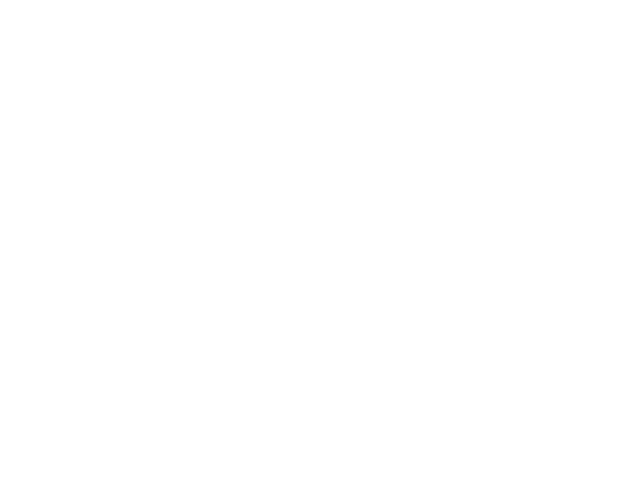

<IPython.core.display.Javascript object>

In [6]:
%matplotlib notebook
color_peak_surroundings(
    atac_split, atac_indices, eco_split, eco_indices
)


### Distance Between Peaks

In [7]:
min_distance = np.min(
    scipy.spatial.distance.cdist(
        atac_indices[:, np.newaxis], eco_indices[:, np.newaxis]
    ),
    axis=1,
)

<IPython.core.display.Javascript object>

Text(0.5, 0, 'Distance [bp]')

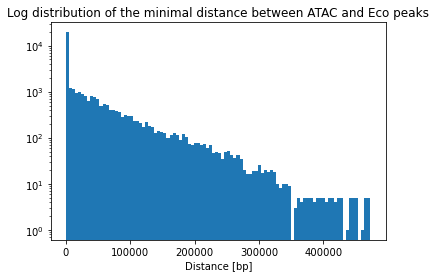

<IPython.core.display.Javascript object>

In [8]:
%matplotlib inline
fig, ax = plt.subplots()
ax.hist(min_distance, bins=100)
ax.set_yscale("log")
ax.set_title("Log distribution of the minimal distance between ATAC and Eco peaks")
ax.set_xlabel("Distance [bp]")

In [9]:
len((min_distance[min_distance <= 1000])) / len(min_distance)

0.5110868377935555

<IPython.core.display.Javascript object>

As shown by the calculation above, about 50% of peaks ATAC peaks are closer than 1 kb to the nearest Eco peak.

## ATAC Peak Widths

It appears that the peak width determins whether that specific ATAC peaks refers to an open area or not. Thus we'll try to filter the peaks accordingly. After the conversation with Michal, a former PostDoc in Yuval's lab, we realized that the peak widths data has to be combined with peak calling, since that second filter guarantees that we're working with high quality data. 

For basic QC we'll use `deeptools`, an assortment of command line tools. A useful subcommand here is `bamPEFragmentSize` that generates a histogram of the fragment length distribution (run it from inside the `hmm_output` directory):

`bamPEFragmentSize -o ../fragmentsize.png --maxFragmentLength 1000 -b ENCFF240YRV.sorted.bam --outRawFragmentLengths ../raw_lengths.tsv`

![Fragment size distribution](/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/fragmentsize.png)

This looks great - we have the NFR, Mono, Di, etc. peaks that we're looking for. This is aggregate data, though - we need to filter the reads based on these values. We'll do so in two ways, mainly because I'm not sure that what I'm doing is correct. The first way is again using `deeptools`, but this time using another subcommand called `bamCoverage`:

`bamCoverage -b ENCFF240YRV.sorted.bam -o ../ENCFF240YRV.sorted.bigwig --maxFragmentLength 100 -p 8`

This generates a BigWig file that contains only the <100 fragment length reads. Changing the suffix to `.bedgraph` will generate a BedGraphFile file, but BigWigs are easier on IGV. This command parses the whole genome and takes quite a while, but the results are exactly what we need - only the ATAC areas that mark a NFR.

Just as a reference, I've also generated a BedGraph using `./bigWigToBedGraph /mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/hmm_output/ENCFF240YRV.sorted.bigwig /mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/hmm_output/ENCFF240YRV.sorted.nfr.bedgraph` (visit http://hgdownload.cse.ucsc.edu/admin/exe/linux.x86_64/ for the binary).

The second way to arrive at the same results is through manual iteration of the reads in the BAM file, showcased below only for chromosome 15. This process is slower (Python) but there's less "magic" involved, and more elaborate processing can be done if needed. The code below first generates the same read length histogram shown above, and then generates a BedGraphFile file with the same data.

In [27]:
import pysam

fname = (
    "/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/hmm_output/ENCFF240YRV.sorted.bam"
)
bamfile = pysam.AlignmentFile(fname, "rb")
lengths = []
starts = []
ends = []
for row in bamfile.fetch():
    try:
        if row.reference_name != "chr15":
            continue
        starts.append(row.reference_start)
        ends.append(row.reference_end)
        lengths.append(row.template_length)
    except AttributeError:
        continue
lengths = np.asarray(lengths)
starts = np.asarray(starts)
ends = np.asarray(ends)

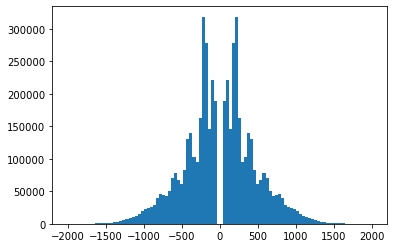

In [28]:
fig, ax = plt.subplots()
_ = ax.hist(lengths, bins=100)

In [24]:
nfr = (lengths >= 0) & (lengths <= 100)
starts = starts[nfr]
ends = ends[nfr]
lengths = lengths[nfr]
intensities = lengths.copy()
intensities[:] = 1

In [ ]:
df = pd.DataFrame({'chr': 'chr15', 'start_locus': starts, 'end_locus': ends, 'intensity': intensities})
df.to_csv('/mnt/saphyr/Saphyr_Data/DAM_DLE_VHL_DLE/Hagai/ENCFF240YRV_nfr.bedgraph', header=None, index=False, sep='\t')

Looking at IGV the results are basically identical - which is great. We can definitely move onward with confidence, and check the Chromatin values at these locations.

In [11]:
df = pd.DataFrame({'a': [1, 2, 3]})
df

,a
0,1
1,2
2,3


In [13]:
df.bg

AttributeError: Must have all needed columns